# About 

This notebook is intended to be a POC for Experiment 4.1 in the Skantze 2017 paper. 

## Setup 

In [1]:
 # Download libraries for environment. 

import sys 
import os 

# Env. vars to check if the notebook is running on colab, kaggle etc. 
IS_COLAB = "google.colab" in sys.modules 
IS_KAGGLE = "kaggle_secrets" in sys.modules 
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

if IS_COLAB:
    # Install the packages 
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers
    %pip install -q -U datasets
    print("You can safely ignore the package incompatibility errors.")
    # Mount the drive 
    from google.colab import drive 
    drive.mount("/drive")

In [8]:

import os
import pandas as pd
import numpy as np
from copy import deepcopy 

import random 
import shutil 
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Pytorch imports 
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

# Others 
import glob 

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




In [3]:
# --  Set environment global vars. 

# Shared env. vars. 
GLOBAL_SEED = 42 
IS_CUDA_ENV = torch.cuda.is_available()
GLOBAL_DEVICE = torch.device('cuda') if IS_CUDA_ENV else torch.device('cpu')
SET_SEED = True # If true, sets the global seeds for this notebook. 
LIMITED_RESOURCES = not IS_CUDA_ENV

if LIMITED_RESOURCES:
    SMALL_DATASET_SIZE = 10

if IS_COLAB:
    LIMITED_RESOURCES = False 
   

In [4]:
# Configuring env. 
if SET_SEED:
    # to make this notebook's output stable across runs
    np.random.seed(GLOBAL_SEED) 
    torch.manual_seed(GLOBAL_SEED)

In [5]:
# Project Paths
NOTEBOOK_NAME = "skantze2017_exp_4.1_poc"
PROJECT_ROOT_DIR = "/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous" 
# --- Input data dirs. 

FULL_DATALOADER_DIR = os.path.join(PROJECT_ROOT_DIR, "data","processed", "skantze2017_maptask_dataset_poc","full")
PROSODY_DATALOADER_DIR = os.path.join(PROJECT_ROOT_DIR, "data","processed", "skantze2017_maptask_dataset_poc","prosody")

# --- Result dirs. 
# NOTE: The model dir will have to change depending on where the models are stored. 
REPORTS_DIR = os.path.join(PROJECT_ROOT_DIR,"reports",NOTEBOOK_NAME)
SAVE_MODELS_DIR =  os.path.join(PROJECT_ROOT_DIR,"models",NOTEBOOK_NAME)

os.makedirs(REPORTS_DIR,exist_ok=True)
os.makedirs(SAVE_MODELS_DIR,exist_ok=True)


In [46]:
# Paths to the specific feature sets 
FULL_PROCESSED_FEATURE_DIR = os.path.join(PROJECT_ROOT_DIR,"data", "processed", "maptask","full")
PROSODY_PROCESSED_FEATURE_DIR = os.path.join(PROJECT_ROOT_DIR,"data", "processed", "maptask","prosody")
FULL_PROCESSED_FEATURE_DIR

'/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous/data/processed/maptask/full'

In [198]:
def save_fig(path, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Required Code 

**NOTE** In this section, we are copying some required code from notebooks 1.0-* to 3.0-*.

Ay bugs in this code **should be fixed in the appropriate notebooks**. 

### MapTask Dataset Generation Code

In [36]:
RAW_DATA_DIR = os.path.join(PROJECT_ROOT_DIR,"data", "raw", "maptask")
MAPTASK_DIR = os.path.join(RAW_DATA_DIR,"maptaskv2-1")
# Paths within the maptask corpus 
STEREO_AUDIO_PATH = os.path.join(MAPTASK_DIR,"Data/signals/dialogues")
MONO_AUDIO_PATH = os.path.join(MAPTASK_DIR,"Data/signals/mono_signals")
# NOTE: The timed units are also used for Voice Activity annotations. 
TIMED_UNIT_PATHS = os.path.join(MAPTASK_DIR,"Data/timed-units") 
POS_PATH = os.path.join(MAPTASK_DIR,"Data/pos")


In [37]:
def get_maptask_participant(csv_path):
    filename, ext = os.path.splitext(os.path.basename(csv_path))
    filename_split = filename.split(".")
    participant = filename_split[1]
    return participant

def get_maptask_dialogue(csv_path):
    filename, ext = os.path.splitext(os.path.basename(csv_path))
    filename_split = filename.split(".")
    dialogue = filename_split[0]
    return dialogue

def read_data(dir_path,dialogue_name, participant,ext):
    """
    Assumption is that the basename . is the dialogue name. 
    """
    results = []
    data_paths = [p for p in os.listdir(dir_path)]
    data_paths = [os.path.join(dir_path,p) for p in data_paths if os.path.splitext(p)[1][1:] == ext]
    for path in data_paths:
       if get_maptask_dialogue(path) == dialogue_name and \
                get_maptask_participant(path) == participant:
            results.append(path)
    return results 

def get_mono_audio(dialogue_name, participant):
    return read_data(MONO_AUDIO_PATH,dialogue_name, participant,"wav")[0]

def get_stereo_audio(dialogue_name):
    return read_data(STEREO_AUDIO_PATH,dialogue_name,"mix","wav")[0]

def get_timed_unit(dialogue_name, participant):
    return read_data(TIMED_UNIT_PATHS,dialogue_name, participant,"xml")[0]


In [38]:
def collect_dialogue_features(dialogue_names, features_dir):
    """
    Collect the dialogue f and g feature files.
    Assumes that features_dir contains both the f and g feature files. 
    """
    collected = {}
    for dialogue in dialogue_names:
        collected[dialogue] = {
            "f" : read_data(features_dir,dialogue,"f","csv")[0], 
            "g" : read_data(features_dir,dialogue,"g","csv")[0]}
    return collected 




In [41]:
import random
from copy import deepcopy
from sklearn.model_selection import train_test_split 

In [40]:
def get_train_val_test_dialogues(dataset_paths, test_size=0.25, val_size=0.2, 
        seed=GLOBAL_SEED):
    dataset_paths = deepcopy(dataset_paths)
    dialogue_names = sorted(list(set([get_maptask_dialogue(p) for p in dataset_paths])))
    train_dialogues, test_dialogues = train_test_split(dialogue_names, 
        test_size=test_size,random_state=seed)
    train_dialogues, val_dialogues = train_test_split(train_dialogues, 
        test_size=val_size,random_state=seed)
    return train_dialogues, val_dialogues, test_dialogues 


### MapTask Dataclass and Method Definitions 

These are required to be in the same notebook to be loaded. 


NOTE: **DO NOT** modify these here, refer to 2.0-MU-Skantze-MapTask-Dataset-POC

In [6]:
def extract_voice_activity_labels(feature_df, N):
    # TODO: FIx the delimiter 
    feature_df = feature_df[["frameTime","voiceActivity"]]
    assert not feature_df.isnull().values.any()
    frame_times_ms = np.asarray(feature_df["frameTime"])
    voice_activity_annotations = np.asarray(feature_df["voiceActivity"])
    assert frame_times_ms.shape[0] == voice_activity_annotations.shape[0]
    labels = np.zeros((frame_times_ms.shape[0],N)) # target label shape: Num Frames x N
    for i in range(len(frame_times_ms)):
        # Pad the last labels with 0 if the conversation has ended 
        if i + N > len(frame_times_ms):
            concat = np.concatenate(
                [voice_activity_annotations[i:],
                 np.zeros(N - (len(frame_times_ms)-i))])
            labels[i] = concat
        else:
            labels[i] = voice_activity_annotations[i:i+N]
    labels_df = pd.DataFrame(labels) 
    labels_df.insert(0,"frameTime",frame_times_ms)
    assert not labels_df.isnull().values.any()
    return labels_df 


In [7]:

class Skantze2017VAPredictionMapTaskDataset(Dataset):
    """
    Maptask dataset for voice activity annotation sequence prediction.  
    NOTE: Needs a large amount of memory to load this. 
    """

    def __init__(self, feature_paths_map, sequence_length_ms, 
            prediction_length_ms, target_participant, frame_step_size_ms):
        # Vars. 
        self.feature_paths_map = feature_paths_map 
        self.sequence_length_ms = sequence_length_ms 
        self.prediction_length_ms = prediction_length_ms 
        self.target_participant = target_participant 
        self.frame_step_size_ms = frame_step_size_ms 
        # Calculated 
        self.num_context_frames = int(sequence_length_ms / frame_step_size_ms)
        self.num_target_frames = int(prediction_length_ms / frame_step_size_ms)
        # Storage 
        self.xs = [] 
        self.ys = [] 
        for dialogue in list(self.feature_paths_map.keys()):
            self.__load_data(dialogue)
        assert len(self.xs) == len(self.ys)

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        if idx > self.__len__():
            raise Exception 
        return self.xs[idx], self.ys[idx]

    def __load_data(self, dialogue):
        s0_feature_df, s1_feature_df = self.__load_dataframes(dialogue)
        # Extract the voice activity labels for s0 as the target labels
        s0_target_labels_df = extract_voice_activity_labels(
            s0_feature_df,self.num_target_frames)
        # Make sure none of the dfs have any nan values 
        assert not s0_feature_df.isnull().values.any() and \
            not s1_feature_df.isnull().values.any() and \
            not s0_target_labels_df.isnull().values.any()
        # Trim the dataframes to the same length 
        min_num_frames = np.min([len(s0_feature_df.index),len(s1_feature_df.index)])
        s0_feature_df = s0_feature_df[:min_num_frames]
        s1_feature_df = s1_feature_df[:min_num_frames]
        s0_target_labels_df = s0_target_labels_df[:min_num_frames]
        # Make sure they all have common frametimes
        assert s0_feature_df['frameTime'].equals(s1_feature_df['frameTime'])
        assert s0_feature_df['frameTime'].equals(s0_target_labels_df['frameTime'])
        s0_s1_df = pd.concat([s0_feature_df,s1_feature_df],axis=1)     
        assert not s0_s1_df.isnull().values.any()     
        # Determine the number of sequences for this dialogue 
        num_sequences = int(np.floor(len(s0_feature_df.index))/self.num_context_frames)
        for i in range(num_sequences):
            x = np.asarray(s0_s1_df.loc[:,s0_s1_df.columns != 'frameTime'][i * \
                self.num_context_frames : (i * self.num_context_frames) \
                    + self.num_context_frames])
            y = np.asarray(s0_target_labels_df.loc[:,s0_target_labels_df.columns\
                    != 'frameTime'][i * self.num_context_frames : \
                        (i * self.num_context_frames) + self.num_context_frames])[-1,:]
            self.xs.append(x)
            self.ys.append(y)

    def __load_dataframes(self, dialogue):
        if self.target_participant == "f":
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"], index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",")
        else:
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"],index_col=0,delimiter=",")
        return s0_feature_df, s1_feature_df 



In [9]:
# NOTE:Seed worker can be used to ensure reproducibility in DataLoader 
# across runs. 
def seed_worker(worker_id):
    worker_seed =GLOBAL_SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def generate_dataloader(dataset, batch_size=32, shuffle=True, num_workers=0, 
        drop_last=True, pin_memory=True):
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=num_workers, 
        drop_last=drop_last, # We always want to remove the last incomplete batch. 
        pin_memory=pin_memory, 
        worker_init_fn=seed_worker)

### MapTask Loading Saved Datasets 

In [10]:
from copy import deepcopy 

In [11]:
def load_saved_dataloader_util(feature_set):
    """
    Loads the dataloader saved by the 2.0 notebook. 
    """
    load_dir = FULL_DATALOADER_DIR if feature_set == "full" else PROSODY_DATALOADER_DIR
    dataloaders = [] 
    for dataset_name in ('train','val','test'):
        path = "{}/{}_dataloader_{}.pt".format(load_dir, dataset_name, feature_set)
        dataloader = torch.load(path)
        dataloaders.append(deepcopy(dataloader))
    return dataloaders

### Skantze 2017 Model

In [12]:
class Skantze2017LSTMPredictor(nn.Module):
    # TODO: The seed parameter is used to make sure that the layer initializations 
    # are the same across runs for model comparison - this should probably be 
    # either refactored or replaced.  
    def __init__(self, input_dim, hidden_dim, output_dim, layer_dim=1, seed=None):
        super().__init__()
        # Defining the vars. 
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim
        self.layer_dim = layer_dim
        # LSTM Layers
        if seed != None:
            torch.manual_seed(seed)
        self.lstm = nn.LSTM(input_dim, hidden_dim,layer_dim,batch_first=True) #  tanh activation is the default. 
        # Fully connected layer
        if seed != None:
            torch.manual_seed(seed)
        self.fc = nn.Linear(hidden_dim,output_dim,bias=True)
        if seed != None:
            torch.manual_seed(seed)
        self.fc_activation = nn.Sigmoid()

    def forward(self, x):
        # Initialize the hidden states for first input with zeroes. 
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize the cell state for the first input with zeroes. 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()

        # TODO: Still need to implement TBPTT in the model for the last 10 seconds, 
        # which is what was done in the Skantze paper. 

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x.float(),(h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :] # Because we need the final output. 
        return self.fc_activation(self.fc(out))


### General Training Utility Methods 

In [13]:
# Writing training loop for a single batch 

def train_step(model,optimizer, loss_fn, x, y):
    # Make sure X type is correct. 
    x = x.type(torch.FloatTensor)
    # NOTE: The input should not have any nans. 
    assert not torch.isnan(x).any()
    model.train()
    optimizer.zero_grad()
    y_hat = model(x)
    assert not torch.isnan(y_hat).any()
    assert not torch.isnan(y).any()
    loss = loss_fn(y,y_hat)
    assert not torch.isnan(y).any()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer.step()
    return loss

In [14]:
def validate_step(model, loss_fn, x,y):
    with torch.no_grad():
        model.eval()
        y_hat = model(x)
        loss = loss_fn(y,y_hat).item()
        return loss 


In [15]:
def next_batch(dataloader):
    # Loop over dataset 
    for x_batch ,y_batch in dataloader:
        yield x_batch, y_batch 
    

In [16]:
def train(model,optimizer, loss_fn,train_dataloader, val_dataloader, n_epochs,
        validate_n_epochs=1,save_n_epochs=None, save_fn = None,
        print_n_epochs=None):
    # Set the model to training 
    model.train()

    # Vars. to record results across training 
    training_losses = []
    validation_losses = [] 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0 
        samples = 0.0 

        # Run the training batch 
        for batch_x, batch_y in next_batch(train_dataloader):
            loss = train_step(model, optimizer,loss_fn,batch_x, batch_y)
            # -- Updates loss etc. 
            train_loss += loss.item() * batch_y.size(0) 
            # TODO: Not sure if this is the correct way to get accuracy. 
            samples += batch_y.size(0)
        training_losses.append(train_loss / samples)

        # Run the validation batch
        if epoch % validate_n_epochs == 0:
            batch_val_losses = []
            for batch_x, batch_y in next_batch(val_dataloader):
                loss = validate_step(model, loss_fn,batch_x,batch_y)
                batch_val_losses.append(loss) 
            validation_losses.append(np.mean(batch_val_losses))
        else:
            batch_val_losses = 0.0
        
        # Save the model if required. 
        if (save_n_epochs != None and epoch % save_n_epochs == 0 and save_fn != None) or \
                (save_fn != None and epoch == n_epochs):
            info = {
                "epoch" : epoch, 
                "loss" : train_loss/samples,
                "val_loss" : np.mean(batch_val_losses)}
            save_fn(model ,info)
        # Print if needed 
        if print_n_epochs != None and epoch % print_n_epochs == 0:
            print(f"[{epoch}/{n_epochs}] Training loss: {train_loss/samples:.4f}\t \
                Validation loss: {np.mean(batch_val_losses):.4f}")

    return training_losses, validation_losses


### Skantze2017 Model Specific Training Utility Methods 

In [17]:
# Methods to save and load this specific model. 

import h5py 

def save_for_inference(save_path):
    assert not os.path.isfile(save_path)
    return lambda model, info: (
        torch.save({
            "kwargs" : {
                "input_dim" : model.input_dim, 
                "hidden_dim" : model.hidden_dim,
                "output_dim" : model.output_dim,
                "layer_dim" : model.layer_dim}, 
            "info" : deepcopy(info),
            "model_state_dict" : model.state_dict()}, save_path))
    
def load_for_inference(save_file_path):
    assert os.path.isfile(save_file_path) 
    checkpoint = torch.load(save_file_path)
    model = Skantze2017LSTMPredictor(**checkpoint["kwargs"])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['info']


def save_losses(save_dir, filename):
    assert os.path.isdir(save_dir)
    path = "{}/{}.h5".format(save_dir,filename)
    hf : h5py.File = h5py.File(path,'w')

    def h5_save_losses(grp_name, losses_dict):
        grp = hf.create_group(grp_name)
        for loss_name, losses in losses_dict.items():
            # loss_name = np.asarray(losses) 
            grp.create_dataset(loss_name, data=losses)
        
    return hf, path, h5_save_losses



### Skantze2017 Model Specific Testing Utility Methods 

In [18]:
def evaluate_skantze2017(model, test_dataloader):
    loss_fn = nn.L1Loss()
    losses = [] 
    va_losses = []
    with torch.no_grad():
        model.eval() 
        for x_batch, y_batch in next_batch(test_dataloader):
            x_batch = x_batch.view([1, -1, x_batch.size(-1)])
            y_hat = model(x_batch)
            loss = loss_fn(y_hat, y_batch)
            losses.append(loss) 
            nonzero_target_indices = np.nonzero(y_batch ==1)[:,1]
            if len(nonzero_target_indices) > 0:
                va_loss = loss_fn(
                    y_hat[:,nonzero_target_indices], y_batch[:,nonzero_target_indices])
                va_losses.append(va_loss)
        return losses , va_losses
            

## Experiment 4.1: Visualizing Prediction performance

The following should be varied to vary the results of this experiment:
1. The data set from which the dataloaders are created. Since there is more voice activity for speaker g, that model is predicted to have a lower performance. 




In [206]:
# Parameters for the experiment 
MODEL_NAME = "skantze2017"
FEATURE_SET = "full"
NUM_HIDDEN_NODES = 40 
TARGET_PARTICIPANT = "f"
N_EPOCHS = 10
SEQUENCE_LENGTHS_MS = [60_000]
PREDICTION_LENGTHS_MS = [250, 500,1000,2000,3000]
FRAME_STEP_SIZE_MS = 50 

# Training args. 
PRINT_N_EPOCHS = 1 
SAVE_N_EPOCHS = 1 
LEARNING_RATE = 0.01 
WEIGHT_DECAY = 0.001



In [207]:
FEATURE_SET_DIR = FULL_PROCESSED_FEATURE_DIR if FEATURE_SET == "full" else PROSODY_PROCESSED_FEATURE_DIR

In [208]:
# NOTE: This method needs to be redefined for experiment 4.1 
def save_for_inference(save_dir,model_name):
    assert os.path.isdir(save_dir)
    return lambda model, info: (
        torch.save({
            "kwargs" : {
                "input_dim" : model.input_dim, 
                "hidden_dim" : model.hidden_dim,
                "output_dim" : model.output_dim,
                "layer_dim" : model.layer_dim}, 
            "info" : deepcopy(info),
            "model_state_dict" : model.state_dict()}, 
            os.path.join(save_dir, "{}_{}.pt".format(model_name, info['epoch']))))

In [209]:
# Get dialogue splits 
dataset_csv_paths =  glob.glob("{}/*.csv".format(FEATURE_SET_DIR))
train_dialogues, val_dialogues, test_dialogues = \
    get_train_val_test_dialogues(dataset_csv_paths)
feature_paths_map =  \
    collect_dialogue_features(train_dialogues,FEATURE_SET_DIR)
print(len(train_dialogues), len(val_dialogues), len(test_dialogues))


76 20 32


In [210]:
from tqdm import tqdm 

In [211]:
# --- Training models for the experiment. 

# Creating the loss save function 
hf, hf_save_path, save_loss_fn= save_losses(SAVE_MODELS_DIR, "exp_4.1")

for sequence_length_ms in SEQUENCE_LENGTHS_MS:
    for prediction_length_ms in PREDICTION_LENGTHS_MS:
        print("Running experiment:\nMax Epochs: {}\nSequence length: {}\n"\
                    "prediction length: {}\nFeature set: {}".format(
                        N_EPOCHS,sequence_length_ms,
                        prediction_length_ms, FEATURE_SET))
        # Create the save dir / func for this config. 
        exp_config_name =  "{}_{}_{}_{}".format(sequence_length_ms,
                    prediction_length_ms,FEATURE_SET,N_EPOCHS)
        save_models_dir = os.path.join(SAVE_MODELS_DIR,exp_config_name)
        os.makedirs(save_models_dir,exist_ok=True)
        save_fn = save_for_inference(save_models_dir,MODEL_NAME)
        # Generate the datasets 
        print("Generating datasets...")
        datasets = [] 
        for dialogues in (train_dialogues, val_dialogues, test_dialogues):
            dataset = Skantze2017VAPredictionMapTaskDataset(
                feature_paths_map=collect_dialogue_features(
                                        dialogues,FEATURE_SET_DIR), 
                sequence_length_ms=sequence_length_ms, 
                prediction_length_ms=prediction_length_ms, 
                target_participant=TARGET_PARTICIPANT, 
                frame_step_size_ms=FRAME_STEP_SIZE_MS)
            datasets.append(deepcopy(dataset))
        # Generate the dataloaders 
        print("Generating dataloaders...")
        dataloaders = [] 
        for i, (dataset_name, batch_size) in enumerate(
            zip(('train','val','test'),(32,32,1))):
            dataloader = generate_dataloader(datasets[i],batch_size=batch_size)
            dataloaders.append(dataloader)
        # --- Initialize the model for training 
        model = Skantze2017LSTMPredictor(
            input_dim=next(iter(datasets[0]))[0].shape[-1],
            hidden_dim=NUM_HIDDEN_NODES , 
            output_dim=int(prediction_length_ms/FRAME_STEP_SIZE_MS))
        loss_fn = nn.L1Loss()
        optimizer = torch.optim.RMSprop(
            model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
        # -- Save the eval loss of the untrained model 
        print("Evaluating the untrained model for reference...")
        per_epoch_eval_losses = []
        l1_losses, _ = evaluate_skantze2017(model, dataloaders[-1])
        per_epoch_eval_losses.append(np.mean(l1_losses))
        # -- Start training 
        print("Training models...")
        training_losses, val_losses = train(
            model,optimizer, loss_fn,dataloaders[0], dataloaders[1], 
            n_epochs=N_EPOCHS+1, print_n_epochs=PRINT_N_EPOCHS,
            save_fn=save_fn,save_n_epochs=SAVE_N_EPOCHS)
        # -- Evaluate the models 
        # The evaluation is the average evaluation loss for models trained 
        # utpo epoch N. 
        print("Evaluating models...")
        model_paths = sorted(glob.glob("{}/*.pt".format(save_models_dir))) 
        for model_path in tqdm(model_paths):
            model, info = load_for_inference(model_path)
            model.eval()
            l1_losses, _ = evaluate_skantze2017(model, dataloaders[-1])
            per_epoch_eval_losses.append(np.mean(l1_losses))
        # Save losses for the final epoch of this configuration.
        # NOTE: These losses are the per epoch loss for every epoch. 
        save_loss_fn(
            exp_config_name, {
                "per_epoch_training" : training_losses, 
                "per_epoch_validation" : val_losses, 
                "per_epoch_eval" : per_epoch_eval_losses})
hf.close()
        

Running experiment:
Max Epochs: 10
Sequence length: 60000
prediction length: 250
Feature set: full
Generating datasets...
Generating dataloaders...
Evaluating the untrained model for reference...
Training models...
[1/11] Training loss: 0.3553	                 Validation loss: 0.1672
[2/11] Training loss: 0.1352	                 Validation loss: 0.1553
[3/11] Training loss: 0.1483	                 Validation loss: 0.1325
[4/11] Training loss: 0.0822	                 Validation loss: 0.1242
[5/11] Training loss: 0.0829	                 Validation loss: 0.1114
[6/11] Training loss: 0.0441	                 Validation loss: 0.1080
[7/11] Training loss: 0.0420	                 Validation loss: 0.1093
[8/11] Training loss: 0.0338	                 Validation loss: 0.1123
[9/11] Training loss: 0.0434	                 Validation loss: 0.1128
[10/11] Training loss: 0.0595	                 Validation loss: 0.1282
[11/11] Training loss: 0.0664	                 Validation loss: 0.1080
Evaluating mo

100%|██████████| 11/11 [00:50<00:00,  4.60s/it]


Running experiment:
Max Epochs: 10
Sequence length: 60000
prediction length: 500
Feature set: full
Generating datasets...
Generating dataloaders...
Evaluating the untrained model for reference...
Training models...
[1/11] Training loss: 0.3413	                 Validation loss: 0.2226
[2/11] Training loss: 0.1956	                 Validation loss: 0.2038
[3/11] Training loss: 0.1436	                 Validation loss: 0.1932
[4/11] Training loss: 0.1249	                 Validation loss: 0.1804
[5/11] Training loss: 0.1217	                 Validation loss: 0.1748
[6/11] Training loss: 0.1019	                 Validation loss: 0.1762
[7/11] Training loss: 0.1000	                 Validation loss: 0.1684
[8/11] Training loss: 0.0846	                 Validation loss: 0.1706
[9/11] Training loss: 0.0737	                 Validation loss: 0.1706
[10/11] Training loss: 0.0962	                 Validation loss: 0.1700
[11/11] Training loss: 0.1103	                 Validation loss: 0.1682
Evaluating mo

100%|██████████| 11/11 [00:49<00:00,  4.47s/it]


Running experiment:
Max Epochs: 10
Sequence length: 60000
prediction length: 1000
Feature set: full
Generating datasets...
Generating dataloaders...
Evaluating the untrained model for reference...
Training models...
[1/11] Training loss: 0.3893	                 Validation loss: 0.2301
[2/11] Training loss: 0.2865	                 Validation loss: 0.2253
[3/11] Training loss: 0.1814	                 Validation loss: 0.2214
[4/11] Training loss: 0.2194	                 Validation loss: 0.2180
[5/11] Training loss: 0.1812	                 Validation loss: 0.2185
[6/11] Training loss: 0.1737	                 Validation loss: 0.2092
[7/11] Training loss: 0.1553	                 Validation loss: 0.2214
[8/11] Training loss: 0.1747	                 Validation loss: 0.2072
[9/11] Training loss: 0.1691	                 Validation loss: 0.2098
[10/11] Training loss: 0.1435	                 Validation loss: 0.2056
[11/11] Training loss: 0.1392	                 Validation loss: 0.2032
Evaluating m

100%|██████████| 11/11 [00:51<00:00,  4.64s/it]


Running experiment:
Max Epochs: 10
Sequence length: 60000
prediction length: 2000
Feature set: full
Generating datasets...
Generating dataloaders...
Evaluating the untrained model for reference...
Training models...
[1/11] Training loss: 0.3457	                 Validation loss: 0.2209
[2/11] Training loss: 0.2356	                 Validation loss: 0.2212
[3/11] Training loss: 0.2234	                 Validation loss: 0.2194
[4/11] Training loss: 0.2084	                 Validation loss: 0.2218
[5/11] Training loss: 0.2080	                 Validation loss: 0.2212
[6/11] Training loss: 0.2136	                 Validation loss: 0.2217
[7/11] Training loss: 0.2187	                 Validation loss: 0.2217
[8/11] Training loss: 0.2326	                 Validation loss: 0.2211
[9/11] Training loss: 0.2121	                 Validation loss: 0.2186
[10/11] Training loss: 0.2173	                 Validation loss: 0.2209
[11/11] Training loss: 0.2120	                 Validation loss: 0.2193
Evaluating m

100%|██████████| 11/11 [00:51<00:00,  4.65s/it]


Running experiment:
Max Epochs: 10
Sequence length: 60000
prediction length: 3000
Feature set: full
Generating datasets...
Generating dataloaders...
Evaluating the untrained model for reference...
Training models...
[1/11] Training loss: 0.3977	                 Validation loss: 0.2164
[2/11] Training loss: 0.2698	                 Validation loss: 0.2225
[3/11] Training loss: 0.2365	                 Validation loss: 0.2132
[4/11] Training loss: 0.2396	                 Validation loss: 0.2149
[5/11] Training loss: 0.2481	                 Validation loss: 0.2169
[6/11] Training loss: 0.2259	                 Validation loss: 0.2155
[7/11] Training loss: 0.2340	                 Validation loss: 0.2136
[8/11] Training loss: 0.2314	                 Validation loss: 0.2154
[9/11] Training loss: 0.2378	                 Validation loss: 0.2150
[10/11] Training loss: 0.2444	                 Validation loss: 0.2167
[11/11] Training loss: 0.2489	                 Validation loss: 0.2152
Evaluating m

100%|██████████| 11/11 [00:53<00:00,  4.88s/it]


In [212]:
from collections import defaultdict

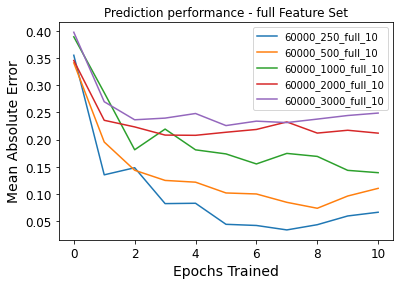

Saving figure Exp-4.1-Figure-3-full


<Figure size 432x288 with 0 Axes>

In [213]:
with h5py.File(hf_save_path,'r') as hf:
    keys = list(hf.keys())
    keys.sort(key=lambda grp_name : int(grp_name.split('_')[1]))
    plt.figure()
    for desc in keys:
        per_epoch_eval_losses = np.asarray(hf[desc]["per_epoch_training"])
        plt.plot(per_epoch_eval_losses, label=desc) 
    plt.title("Prediction performance - {} Feature Set".format(FEATURE_SET))
    plt.xlabel("Epochs Trained")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.show()
    save_fig(REPORTS_DIR,"Exp-4.1-Figure-3-{}".format(FEATURE_SET)) 